In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *
       
def create_char_list(char_set, smile_series):
    for smile in smile_series:
        char_set.update(set(smile))
    return char_set

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 110us/step - loss: 191.4213 - decoder_loss: 183.8182 - qspr_loss: 0.5239 - val_loss: 173.0494 - val_decoder_loss: 167.6740 - val_qspr_loss: 0.4641
Epoch 2/50
60000/60000 [==============================] - 6s 96us/step - loss: 170.8560 - decoder_loss: 165.5098 - qspr_loss: 0.4542 - val_loss: 168.6123 - val_decoder_loss: 163.1449 - val_qspr_loss: 0.4411
Epoch 3/50
60000/60000 [==============================] - 6s 95us/step - loss: 167.2128 - decoder_loss: 161.7009 - qspr_loss: 0.4358 - val_loss: 165.7747 - val_decoder_loss: 160.2148 - val_qspr_loss: 0.4248
Epoch 4/50
60000/60000 [==============================] - 6s 94us/step - loss: 164.9068 - decoder_loss: 159.3105 - qspr_loss: 0.4229 - val_loss: 164.3379 - val_decoder_loss: 158.8749 - val_qspr_loss: 0.4159
Epoch 5/50
60000/60000 [==============================] - 6s 95us/step - loss: 163.3490 - decoder_loss: 157.6773 - qspr_l

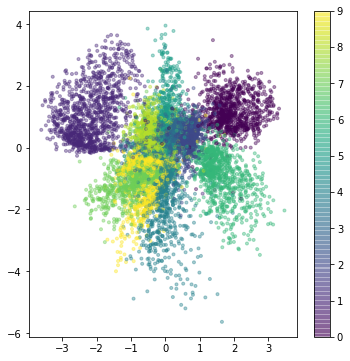

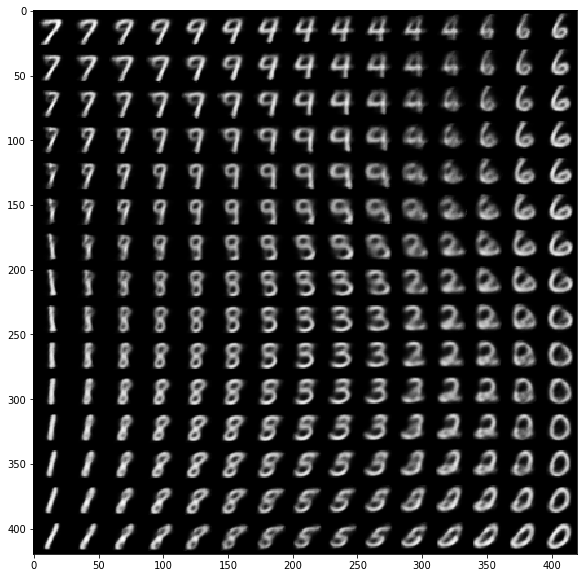

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid', name='decoder_output')
], name='decoder')

qspr = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(1, activation='sigmoid', name='qspr_output') #return 1 for even, 0 for odd
], name='qspr')

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)
# x_pred.name = 'decoder'
qspr_pred = qspr(z)
# qspr_pred.name = 'qspr'

vae = Model(inputs=[x, eps], outputs=[x_pred, qspr_pred])
vae.compile(optimizer='rmsprop', loss={'decoder': nll, 'qspr': 'binary_crossentropy'})

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.
qspr_train = []
for num in y_train:
    if num % 2 == 0:
        qspr_train.append(1)
    else:
        qspr_train.append(0)
qspr_train = np.array(qspr_train)

qspr_test = []
for num in y_test:
    if num % 2 == 0:
        qspr_test.append(1)
    else:
        qspr_test.append(0)
qspr_test = np.array(qspr_test)

vae.fit(x_train,
        [x_train, qspr_train],
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, [x_test, qspr_test]),
        verbose=1)

encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()

In [87]:
import pandas as pd
pd.DataFrame([y_test[:20], np.round(qspr.predict(z_test)[:20]), qspr_test[:20]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4
1,[0.0],[1.0],[0.0],[1.0],[1.0],[0.0],[0.0],[0.0],[0.0],[0.0],[1.0],[1.0],[0.0],[1.0],[0.0],[0.0],[1.0],[0.0],[0.0],[1.0]
2,0,1,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1


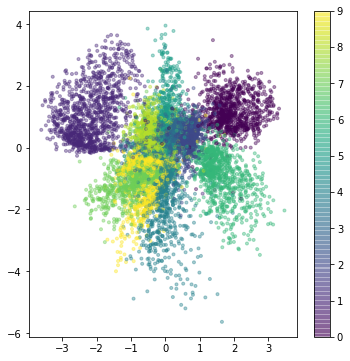

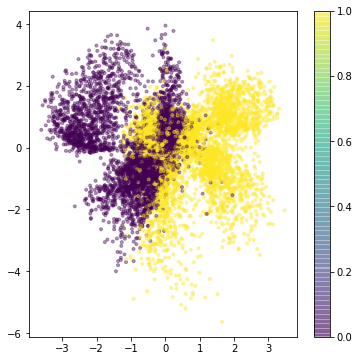

In [88]:

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=qspr_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 105us/step - loss: 191.8903 - val_loss: 171.8820
Epoch 2/50
60000/60000 [==============================] - 6s 94us/step - loss: 170.2449 - val_loss: 167.6121
Epoch 3/50
60000/60000 [==============================] - 6s 94us/step - loss: 166.8917 - val_loss: 165.5490
Epoch 4/50
60000/60000 [==============================] - 6s 93us/step - loss: 164.7146 - val_loss: 164.6107
Epoch 5/50
60000/60000 [==============================] - 6s 93us/step - loss: 163.2019 - val_loss: 162.3637
Epoch 6/50
60000/60000 [==============================] - 6s 93us/step - loss: 162.0531 - val_loss: 161.6633
Epoch 7/50
60000/60000 [==============================] - 6s 93us/step - loss: 161.0799 - val_loss: 160.8615
Epoch 8/50
60000/60000 [==============================] - 6s 93us/step - loss: 160.1870 - val_loss: 160.1020
Epoch 9/50
60000/60000 [==============================] - 5s 91us/step - loss

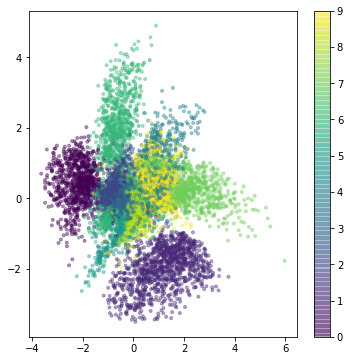

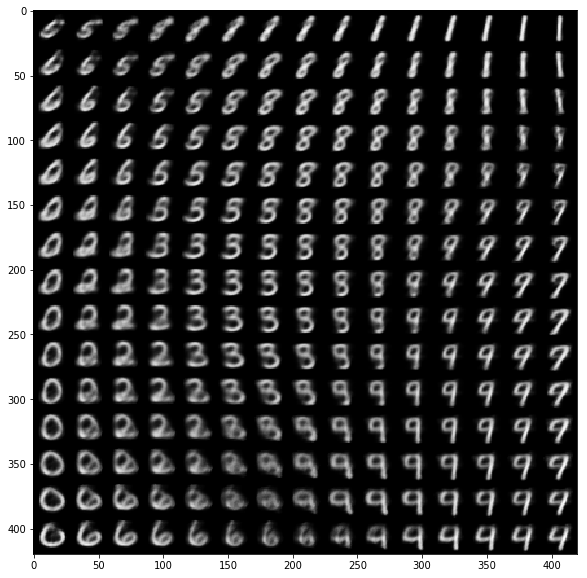

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=1)

encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()

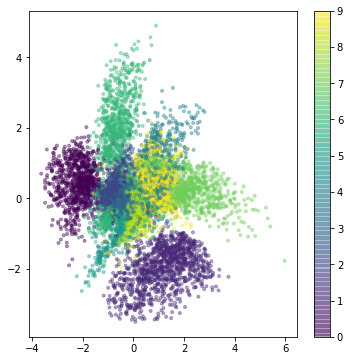

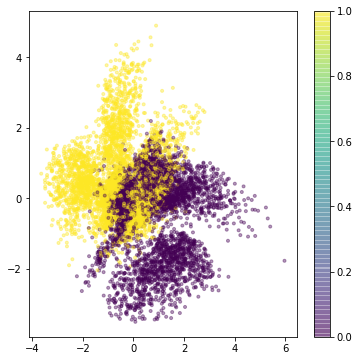

In [90]:

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=qspr_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# Density Data Training

In [5]:
#training array info
smile_max_length = 105
import json
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())

#chars needed for 2 mol w/ anions
char_to_index['.'] = 33
char_to_index['@'] = 34
char_to_index['e'] = 35
char_to_index['/'] = 36

char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#training data
chemvae = MoleculeVAE()

In [12]:
name = 'gen3_2mol_qspr_density_ATP_10_epoch.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name, qspr=True)

In [13]:
properties = ['density']
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
props = properties
devmodel = salty.aggregate_data(props, T=T, P=P, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)
print(salts.shape)

(5631,)


In [14]:
values = salts
print(values[0])
print(values.iloc[-1])
print(len(values))
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
X_train = np.zeros((values.shape[0], smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data['Specific density, kg/m<SUP>3</SUP>'])
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

CCCC[n+]1ccc(cc1)C.[B-](F)(F)(F)F
C1=C[N+](CCCC)=CN1C.C(C(F)(F)F)(C(F)(F)S(=O)(=O)[O-])F
5631


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42) 

In [17]:
chemvae.autoencoder.fit(X_train, [X_train, Y_train],
                        shuffle = False,
                        validation_data=(X_test, [X_test, Y_test]),
                        epochs=100)
chemvae.save('gen3_2mol_qspr_density_ATP_100_epoch.h5')

Train on 5067 samples, validate on 564 samples
Epoch 1/100
5067/5067 [==============================] - 260s 51ms/step - loss: 4.1508 - decoded_mean_loss: 2.8421 - qspr_loss: 1.3087 - decoded_mean_acc: 0.7682 - decoded_mean_mean_squared_error: 0.0076 - qspr_acc: 0.0000e+00 - qspr_mean_squared_error: 1.3087 - val_loss: 2.5402 - val_decoded_mean_loss: 2.4828 - val_qspr_loss: 0.0573 - val_decoded_mean_acc: 0.7960 - val_decoded_mean_mean_squared_error: 0.0068 - val_qspr_acc: 0.0000e+00 - val_qspr_mean_squared_error: 0.0573
Epoch 2/100
5067/5067 [==============================] - 263s 52ms/step - loss: 3.8215 - decoded_mean_loss: 2.5966 - qspr_loss: 1.2248 - decoded_mean_acc: 0.7860 - decoded_mean_mean_squared_error: 0.0070 - qspr_acc: 0.0000e+00 - qspr_mean_squared_error: 1.2248 - val_loss: 2.5426 - val_decoded_mean_loss: 2.5031 - val_qspr_loss: 0.0395 - val_decoded_mean_acc: 0.8046 - val_decoded_mean_mean_squared_error: 0.0068 - val_qspr_acc: 0.0000e+00 - val_qspr_mean_squared_error: 0.03

In [8]:
chemvae.autoencoder.fit(X_train, [X_train, Y_train],
                        shuffle = False,
                        validation_data=(X_test, [X_test, Y_test]),
                        epochs=10)
chemvae.save('gen3_2mol_qspr_density_ATP_10_epoch.h5')

Train on 5067 samples, validate on 564 samples
Epoch 1/10
5067/5067 [==============================] - 159s 31ms/step - loss: 8.4604 - decoded_mean_loss: 5.1643 - qspr_loss: 3.2961 - decoded_mean_acc: 0.6697 - decoded_mean_mean_squared_error: 0.0120 - qspr_acc: 0.0000e+00 - qspr_mean_squared_error: 3.2961 - val_loss: 4.3091 - val_decoded_mean_loss: 3.7697 - val_qspr_loss: 0.5394 - val_decoded_mean_acc: 0.7039 - val_decoded_mean_mean_squared_error: 0.0095 - val_qspr_acc: 0.0000e+00 - val_qspr_mean_squared_error: 0.5394
Epoch 2/10
5067/5067 [==============================] - 160s 32ms/step - loss: 5.0284 - decoded_mean_loss: 3.4436 - qspr_loss: 1.5848 - decoded_mean_acc: 0.7213 - decoded_mean_mean_squared_error: 0.0088 - qspr_acc: 0.0000e+00 - qspr_mean_squared_error: 1.5848 - val_loss: 4.1250 - val_decoded_mean_loss: 3.3813 - val_qspr_loss: 0.7437 - val_decoded_mean_acc: 0.7244 - val_decoded_mean_mean_squared_error: 0.0087 - val_qspr_acc: 0.0000e+00 - val_qspr_mean_squared_error: 0.7437

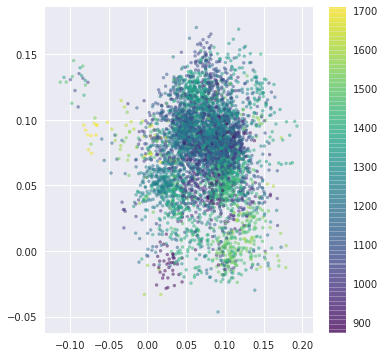

In [9]:
# display a 2D plot of the digit classes in the latent space
z_test = chemvae.encoder.predict(X_train)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

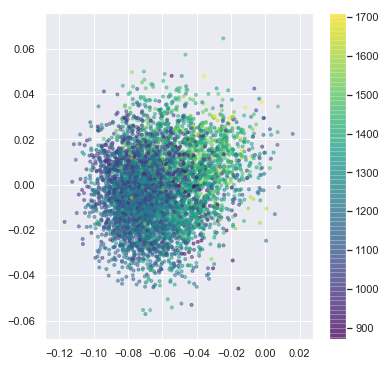

In [38]:
# display a 2D plot of the digit classes in the latent space
z_test = chemvae.encoder.predict(X_train)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

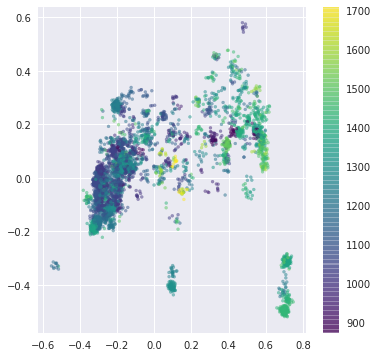

In [10]:
# display a 2D plot of the digit classes in the latent space
z_test = chemvae.encoder.predict(X_train)
pca = PCA(n_components=2)
pcs = pca.fit_transform(z_test)
plt.figure(figsize=(6, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

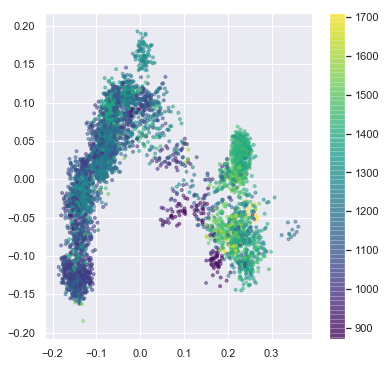

In [40]:
# display a 2D plot of the digit classes in the latent space
z_test = chemvae.encoder.predict(X_train)
pca = PCA(n_components=2)
pcs = pca.fit_transform(z_test)
plt.figure(figsize=(6, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [34]:
values = salts
print(values[0])
print(values.iloc[-1])
print(len(values))
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
X = np.zeros((values.shape[0], smile_max_length, chars_in_dict), dtype=np.float32)
Y = np.array(devmodel.Data['Specific density, kg/m<SUP>3</SUP>'])
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X[i, j, char_to_index[char]] = 1

CCCC[n+]1ccc(cc1)C.[B-](F)(F)(F)F
C1=C[N+](CCCC)=CN1C.C(C(F)(F)F)(C(F)(F)S(=O)(=O)[O-])F
5631


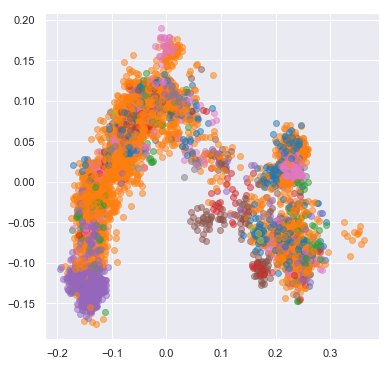

In [35]:
fig, axs = plt.subplots(1, figsize=(6,6), sharex=True, sharey=True)
z = chemvae.encoder.predict(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(z)
for i in range(len(categories)):
        axs.plot(pcs[i,0], 
                        pcs[i,1],
                 linestyle='', marker='.', markersize=12,
                    color=coldic[categories[i]], alpha=0.5, label=categories[i])

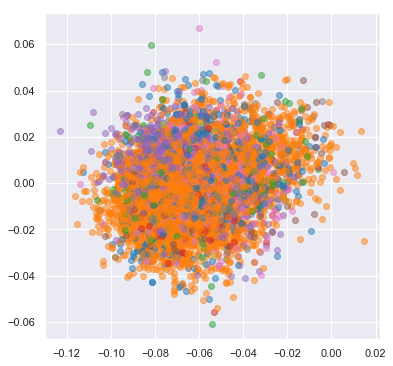

In [37]:
fig, axs = plt.subplots(1, figsize=(6,6), sharex=True, sharey=True)
for i in range(len(categories)):
        axs.plot(z[i,0], 
                        z[i,1],
                 linestyle='', marker='.', markersize=12,
                    color=coldic[categories[i]], alpha=0.5, label=categories[i])